<a href="https://colab.research.google.com/github/ningjingzhiyuan507/AnalysisTool/blob/master/d2l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 配置GPU版本pytorch

In [19]:
!pip install torch==1.8.1
!pip install torchvision==0.9.1

In [20]:
!pip install d2l==0.17.3

In [25]:
!pip install timm==0.4.12

     |████████████████████████████████| 376 kB 5.3 MB/s 
  Attempting uninstall: timm
    Found existing installation: timm 0.3.2
    Uninstalling timm-0.3.2:
      Successfully uninstalled timm-0.3.2


In [26]:
# 测试GPU
import torch
from torch import nn
from d2l import torch as d2l

ImportError: ignored

In [ ]:
!nvidia-smi

Wed Apr  6 03:46:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.device_count()  # 仅有一个GPU

1

In [ ]:
X = torch.rand(2, 3, device='cuda:0')

In [ ]:
X

tensor([[0.5041, 0.4009, 0.8702],
        [0.5575, 0.4337, 0.0781]], device='cuda:0')

# LeNet-5

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
batchSize = 256
trainIter, testIter = d2l.load_data_fashion_mnist(batch_size=batchSize)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def evaluateAccuracyGpu(net, dataIter, device=None):
  """使用GPU计算模型在数据集上的精度"""
  if isinstance(net, nn.Module):
    net.eval()  # 设置为评估模式
    if not device:
      device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
      for X, y in dataIter:
        if isinstance(X, list):
          X = [x.to(device) for x in X]
        else:
          X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, trainIter, testIter, numEpochs, lr, device):
  """用GPU训练模型"""
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)  # 使用Xavier随机初始化模型参数
  net.apply(init_weights)
  print("training on", device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, numEpochs], legend=['train loss', 'train acc', 'test acc'])
  timer, numBatches = d2l.Timer(), len(trainIter)
  for epoch in range(numEpochs):
    # 训练损失之和，训练准确率之和，样本数
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(trainIter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      yHat = net(X)
      l = loss(yHat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(yHat, y), X.shape[0])
      timer.stop()
      trainL = metric[0] / metric[2]
      trainAcc = metric[1] / metric[2]
      if (i+1) % (numBatches // 5) == 0 or i == numBatches - 1:
        animator.add(epoch + (i+1) / numBatches, (trainL, trainAcc, None))
    testAcc = evaluateAccuracyGpu(net, testIter)
    animator.add(epoch + 1, (None, None, testIter))
  print(f'loss {trainL: .3f}, train acc {trainAcc:.3f},'
        f'test acc {testAcc:.3f}')
  print(f'{metric[2] * numEpochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

TypeError: ignored

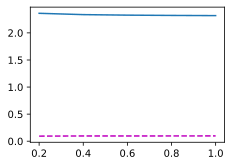

In [ ]:
lr, numEpochs = 0.9, 10
train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

loss 0.494, train acc 0.812, test acc 0.783
24635.0 examples/sec on cuda


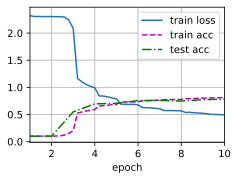

In [ ]:
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

# 现代卷积神经网络

## AlexNet

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    # 这里我们使用一个11*11的更大窗口来捕捉对象（image图像比LeNet使用的图像都要大10倍以上）
    # 同时，步幅为4以减少输出的高度和宽度
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用padding为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，pooling不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10
    nn.Linear(4096, 10)
)

In [ ]:
batchSize = 128
trainIter, testIter = d2l.load_data_fashion_mnist(batchSize, resize=224)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!pip uninstall matplotlib
!pip install matplotlib

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
y
  Successfully uninstalled matplotlib-3.5.1
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

loss 0.328, train acc 0.880, test acc 0.883
1411.3 examples/sec on cuda


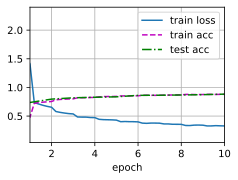

In [ ]:
lr, numEpochs = 0.01, 10
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

## VGG

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    )
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # 卷积层部分
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # 全连接层部分
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10)
  )

In [ ]:
net = vgg(conv_arch)

In [ ]:
# 测试
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.178, train acc 0.934, test acc 0.915
660.3 examples/sec on cuda


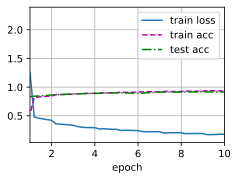

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

## NiN

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

ImportError: ignored